In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from tqdm import tqdm
%matplotlib inline
plt.ioff()

In [2]:
from hamest import *
import keras
from keras.models import Sequential
from keras.optimizers import Adam, Nadam
from ringham import *

n=3
batch_size = 512

nb_drives = qubitring_ndrives(n)
hs = np.stack([_.full() for _ in qubitring_all_ops(n)])

_epsilons = [0.1]*n
_etas = [0.01]*n
_deltas = [2.]*qubitring_ndrives(n)
jitter = 0.05
s = np.random.RandomState(seed=36)
_epsilons *= s.normal(loc=1., scale=jitter, size=n)
_etas     *= s.normal(loc=1., scale=jitter, size=n)
_deltas   *= s.normal(loc=1., scale=jitter, size=qubitring_ndrives(n))

H0 = qubitring_H0(n, _epsilons, _etas).full()
Hdrives = np.stack([_.full() for _ in qubitring_Hdrives(n, _deltas)])

val_seed = 1
train_seed = 42
validation_data = next(qubitring_datagen(H0, Hdrives, n=n, batch_size=batch_size, Delta=1., seed=val_seed, average_over=float('inf')))

model = Sequential()
model.add(StateProbabilitiesPaulied(nqubits=n, ndrives=nb_drives, paulies=hs,
                                    l1_lambda=0))
model.compile(loss='mse', optimizer=Nadam(lr=5e-4), metrics=['mse', 'mae', 'binary_crossentropy'])

/home/fas/jiang/sk943/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
class FIStateProbabilitiesPaulied(Layer):
    '''Calculate the Fisher Information matrix for a `StateProbabilitiesPaulied` estimator.
    
    XXX There is a lot of code duplication here.
    XXX You have to say the batch size in advance, including when creating the input to this layer.
    '''
    def __init__(self, ndrives, nqubits, paulies, batch_size=512, l1_lambda=None, **kwargs):
        self.ndrives = ndrives
        self.nqubits = nqubits
        self.lenpaulies = paulies.shape[0]
        self.paulies = tf.constant(value=paulies, dtype='complex128')
        self.regularizer_k = L1variable(l1=l1_lambda) if l1_lambda else None
        self.regularizer_b = L1variable(l1=l1_lambda) if l1_lambda else None
        self.batch_size = batch_size
        super().__init__(input_shape=(self.ndrives,), **kwargs)

    def build(self, input_shape):
        w_init = 'normal'
        b_init = 'normal'
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.ndrives,self.lenpaulies,),
                                      initializer=w_init,
                                      trainable=False,
                                      regularizer=self.regularizer_k)
        self.bias = self.add_weight(name='bias', 
                                    shape=(self.lenpaulies,),
                                    initializer=b_init,
                                    trainable=False,
                                    regularizer=self.regularizer_b)
        super().build(input_shape)
        
    def tensorflowH(self, x):
        pauli_weights = K.bias_add(K.dot(x, self.kernel), self.bias)
        self._tensorflowH = tf.tensordot(tf.cast(pauli_weights, 'complex128'), self.paulies, axes=[[1],[0]])
        return self._tensorflowH

    def call(self, x):
        H = self.tensorflowH(x)
        e, v = tf.self_adjoint_eig(H)
        expe = tf.exp(-1j*e)
        amp = tf.einsum('is,ijs->ij', tf.conj(v)[:,0,:]*expe, v)
        P = tf.abs(amp)**2
        oneoverp = 1./P
        def jac(singlep, wrt): # this works on p of shape (2**nqubits,)
            #print(singlep.shape)
            p_list = tf.unstack(singlep,axis=0,)
            jacobian_list = [tf.gradients(p_, wrt)[0] for p_ in p_list]  # list [grad(y0, x), grad(y1, x), ...]
            stack = tf.stack(jacobian_list)
            #print(jacobian_list[0].shape, stack.shape)
            return stack
        def bodywrt(allp,wrt):
            def body(old_g, t):
                g = jac(allp[t,:],wrt)
                new_g = tuple(tf.cond(tf.equal(ti, t),
                                      lambda :g,
                                      lambda :old_g[ti])
                              for ti in range(len(old_g)))
                return new_g, t + 1
            return body
        def cond(_, t):
            return tf.less(t, tf.shape(x)[0])

        p_k = tf.while_loop(cond, bodywrt(P,self.kernel),
                            [(tf.zeros((2**self.nqubits,*self.kernel.shape), dtype='float64'),)*self.batch_size,
                             tf.constant(0)])
        p_b = tf.while_loop(cond, bodywrt(P,self.bias),
                            [(tf.zeros((2**self.nqubits,*self.bias.shape  ), dtype='float64'),)*self.batch_size,
                             tf.constant(0)])
        p_k = tf.stack(p_k[0],name='dpdk')
        p_b = tf.stack(p_b[0],name='dpdb')
        p_b = tf.Print(p_b,[p_b[0,:,0]], summarize=15)
        #print(p_k.shape,p_b.shape,oneoverp.shape)
        I_k = tf.einsum('ipjk,iplm,ip->ijklm', p_k, p_k, oneoverp)
        I_b = tf.einsum('ipj,ipk,ip->ijk', p_b, p_b, oneoverp)
        #print(I_k.shape,I_b.shape)
        return [I_k, I_b]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0], *[self.ndrives,self.lenpaulies]*2),
                (input_shape[0], *[self.lenpaulies]*2)]

In [4]:
i = keras.Input(batch_shape=(batch_size,nb_drives),)
hk,hb = FIStateProbabilitiesPaulied(nqubits=n, ndrives=nb_drives, paulies=hs, batch_size=batch_size)(i)
fi = keras.Model(inputs=[i],outputs=[hk,hb])
fi.compile(loss='mse', optimizer=Nadam(lr=5e-4),)

In [5]:
model.load_weights('./current_test/mod_checkpoint_3_0.0_inf_64_1024')
fi.set_weights(model.get_weights())

In [6]:
validation_data[0].shape

(512, 12)

In [7]:
%time ks, bs = fi.predict(validation_data[0], batch_size=batch_size)

CPU times: user 1min 31s, sys: 5.38 s, total: 1min 37s
Wall time: 29 s


In [8]:
k = np.mean(ks, axis=0)
b = np.mean(bs, axis=0)

In [9]:
s = k.shape
k_flat = np.reshape(k, (s[0]*s[1],s[2]*s[3]))
indices = [i*s[0]+i for i in range(s[0])]
k_onlydiag = k_flat[indices,:][:,indices]

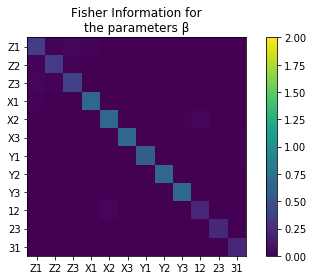

In [126]:
plt.imshow(b,vmin=0,vmax=2)
ticks=['Z1','Z2','Z3','X1','X2','X3','Y1','Y2','Y3','12','23','31']
ax = plt.gca()
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
plt.colorbar()
plt.title('Fisher Information for\nthe parameters β')
plt.tight_layout()
plt.savefig('FI_b.png',dpi=400,bbox_inches='tight');

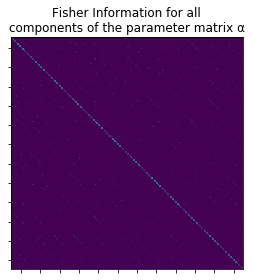

In [127]:
plt.imshow(k_flat,vmin=0,vmax=2)
ax = plt.gca()
ax.set_xticks(range(6,12**2,12))
ax.set_yticks(range(6,12**2,12))
ax.set_xticklabels(['']*12)
ax.set_yticklabels(['']*12)
plt.title('Fisher Information for all\ncomponents of the parameter matrix α')
plt.tight_layout()
plt.savefig('FI_a.png',dpi=400,bbox_inches='tight');

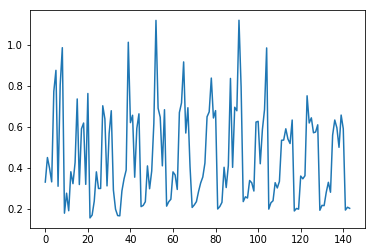

In [12]:
plt.plot(k_flat.diagonal())

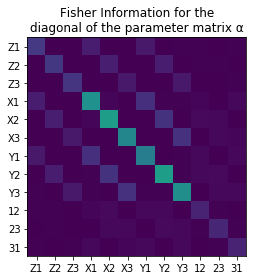

In [128]:
plt.imshow(k_onlydiag,vmin=0,vmax=2)
ax = plt.gca()
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
plt.title('Fisher Information for the\ndiagonal of the parameter matrix α')
plt.tight_layout()
plt.savefig('FI_ad.png',dpi=400,bbox_inches='tight');

In [6]:
class ReLURegularizer(Regularizer):
    '''A naive soft cutoff regularizer.
    
    XXX For production use this need to be annealable.'''
    def __call__(self, x):
        regularization = K.relu(K.mean(K.abs(x)**2)-1)*20
        return regularization

    def get_config(self):
        raise NotImplementedError

class AvgFIStateProbabilitiesPaulied(Layer):
    '''Optimize the drives for maximum Fisher Information (for a `StateProbabilitiesPaulied` estimator).
    
    Looks only at the diagonals of the Fisher Information matrix.
    
    XXX There is a lot of code duplication here (and the gradient is evaluated manually, because the while_loop op is slow and painful)
    XXX You have to say the drive batch size in advance (it is not the input batch size)!
    XXX This is takes input of batch size 1 only (and does not use the input for calculations - a side effect of using Keras for something it is not meant for).
    '''
    def __init__(self, ndrives, nqubits, paulies, batch_size=512, power_reg=None, use_tanh=False, prodloss=False, **kwargs):
        self.ndrives = ndrives
        self.nqubits = nqubits
        self.lenpaulies = paulies.shape[0]
        self.paulies = tf.constant(value=paulies, dtype='complex128')
        self.regularizer_d = ReLURegularizer() if power_reg else None
        self.batch_size = batch_size
        self.use_tanh = use_tanh
        self.prodloss = prodloss
        super().__init__(input_shape=(self.ndrives,), **kwargs)

    def build(self, input_shape):
        w_init = 'normal'
        b_init = 'normal'
        d_init = 'normal'
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.ndrives,self.lenpaulies,),
                                      initializer=w_init,
                                      trainable=False)
        self.bias = self.add_weight(name='bias', 
                                    shape=(self.lenpaulies,),
                                    initializer=b_init,
                                    trainable=False)
        self.drives = self.add_weight(name='bias', 
                                      shape=(self.batch_size, self.ndrives),
                                      initializer=d_init,
                                      trainable=True,
                                      regularizer=self.regularizer_d)
        super().build(input_shape)
        
    def tensorflowH(self, x):
        pauli_weights = K.bias_add(K.dot(x, self.kernel), self.bias)
        self._tensorflowH = tf.tensordot(tf.cast(pauli_weights, 'complex128'), self.paulies, axes=[[1],[0]])
        return self._tensorflowH # indices [batch, hilbert, hilbert]
    
    def call(self, x):
        if self.use_tanh:
            d = K.tanh(self.drives)
        else:
            d = self.drives
        H = self.tensorflowH(d)
        def HtoP(H):
            e, v = tf.self_adjoint_eig(H)
            cv = tf.conj(v)
            expe = tf.exp(-1j*e)
            amp = tf.einsum('is,ijs->ij', cv[:,0,:]*expe, v)
            return tf.abs(amp)**2
        P = HtoP(H)
        oneoverP = 1/P
        delta = tf.constant(1e-6,dtype=tf.complex128) # XXX No, I do not want to talk about this. It haunts my dreams already.
        deltar = tf.cast(delta,tf.float64)
        P_dbias = HtoP(tf.reshape(tf.expand_dims(H,1)+tf.expand_dims(self.paulies,0)*delta,[-1,2**self.nqubits,2**self.nqubits]))
        P_dbias = tf.reshape(P_dbias, [self.batch_size,self.lenpaulies,2**self.nqubits])
        P_dbias = (P_dbias - tf.expand_dims(P,1))/deltar
        P_dkernel = HtoP(tf.reshape(
            tf.expand_dims(tf.expand_dims(H,1),1)+tf.einsum('bp,qij->bpqij',tf.cast(d,tf.complex128),self.paulies)*delta,
            [-1,2**self.nqubits,2**self.nqubits]))
        P_dkernel = tf.reshape(P_dkernel, [self.batch_size,self.ndrives,self.lenpaulies,2**self.nqubits])
        P_dkernel = (P_dkernel - tf.expand_dims(tf.expand_dims(P,1),1))/deltar
        
        I_k = tf.reshape(tf.einsum('bdei,bdei,bi->de', P_dkernel, P_dkernel, oneoverP), [-1])
        I_b = tf.einsum('bdi,bdi,bi->d', P_dbias, P_dbias, oneoverP)
        I = tf.reshape(tf.concat([I_k,I_b],0), [1,-1])/self.batch_size
        if self.prodloss:
            return tf.log(I)
        return I

    def compute_output_shape(self, input_shape):
        return (1, (self.ndrives+1)*self.lenpaulies)
    
def negmean(y_true, y_pred):
    return -tf.reduce_mean(y_pred)
def negmeanexp(y_true, y_pred):
    return -tf.exp(tf.reduce_mean(y_pred))

In [16]:
i = keras.Input(batch_shape=(1,1))
o = AvgFIStateProbabilitiesPaulied(nqubits=n, ndrives=nb_drives, paulies=hs, batch_size=batch_size, power_reg=False, use_tanh=False)(i)
fii = keras.Model(inputs=[i],outputs=[o])
fii.compile(loss=negmean, optimizer=Nadam(lr=0.1))
fii.set_weights([validation_data[0]]+model.get_weights())
%time np.mean(fii.predict(np.array([1]),batch_size=1))

CPU times: user 2.53 s, sys: 87.7 ms, total: 2.62 s
Wall time: 964 ms


0.45772857566786884

In [17]:
i = keras.Input(batch_shape=(1,1))
o = AvgFIStateProbabilitiesPaulied(nqubits=n, ndrives=nb_drives, paulies=hs, batch_size=batch_size, power_reg=False, use_tanh=True)(i)
fio1 = keras.Model(inputs=[i],outputs=[o])
fio1.compile(loss=negmean, optimizer=Nadam(lr=0.1))
fio1.set_weights([validation_data[0]]+model.get_weights())
%time np.mean(fio1.predict(np.array([1]),batch_size=1))

CPU times: user 2.54 s, sys: 80.5 ms, total: 2.63 s
Wall time: 977 ms


0.252073658185657

In [17]:
%%time
fake_data = np.ones((1,))
h1 = fio1.fit(x=fake_data,y=fake_data,batch_size=1,epochs=20,verbose=0)

CPU times: user 1min 26s, sys: 6.41 s, total: 1min 32s
Wall time: 25 s


In [19]:
np.mean(fio1.predict(np.array([1]),batch_size=1))

0.5578511074226239

In [18]:
#fio1.save_weights('optimized_drives1')
fio1.load_weights('optimized_drives1')

In [7]:
i = keras.Input(batch_shape=(1,1))
o = AvgFIStateProbabilitiesPaulied(nqubits=n, ndrives=nb_drives, paulies=hs, batch_size=batch_size, power_reg=True, use_tanh=False)(i)
fio2 = keras.Model(inputs=[i],outputs=[o])
fio2.compile(loss=negmean, optimizer=Nadam(lr=0.05), metrics=[negmean])
fio2.set_weights([validation_data[0]]+model.get_weights())
%time np.mean(fio2.predict(np.array([1]),batch_size=1))

CPU times: user 2.37 s, sys: 61.9 ms, total: 2.43 s
Wall time: 2.2 s


1.0060460678539516

In [21]:
#K.set_value(fio2.optimizer.lr, 0.001)
#K.get_value(fio2.optimizer.lr)

In [22]:
%%time
fake_data = np.ones((1,))
h2 = fio2.fit(x=fake_data,y=fake_data,batch_size=1,epochs=10,verbose=0)

CPU times: user 44.4 s, sys: 3.5 s, total: 47.9 s
Wall time: 13.9 s


In [22]:
np.mean(fio2.predict(np.array([1]),batch_size=1))

0.861749725126653

In [21]:
#fio2.save_weights('optimized_drives2')
fio2.load_weights('optimized_drives2')

In [7]:
i = keras.Input(batch_shape=(1,1))
o = AvgFIStateProbabilitiesPaulied(nqubits=n, ndrives=nb_drives, paulies=hs, batch_size=batch_size, power_reg=True, use_tanh=False, prodloss=True)(i)
fio3 = keras.Model(inputs=[i],outputs=[o])
fio3.compile(loss=negmeanexp, optimizer=Nadam(lr=0.05), metrics=[negmeanexp])
fio3.set_weights([validation_data[0]]+model.get_weights())
%time np.exp(np.mean(fio3.predict(np.array([1]),batch_size=1)))

CPU times: user 2.36 s, sys: 69.7 ms, total: 2.43 s
Wall time: 2.19 s


0.19081894076010306

In [8]:
K.set_value(fio3.optimizer.lr, 0.001)
K.get_value(fio3.optimizer.lr)

0.001

In [67]:
%%time
fake_data = np.ones((1,))
h3 = fio3.fit(x=fake_data,y=fake_data,batch_size=1,epochs=300,verbose=2)

Epoch 1/300
 - 1s - loss: -7.1344e-01 - negmeanexp: -7.1344e-01
Epoch 2/300
 - 1s - loss: -7.1540e-01 - negmeanexp: -7.1540e-01
Epoch 3/300
 - 1s - loss: -7.1639e-01 - negmeanexp: -7.1639e-01
Epoch 4/300
 - 1s - loss: -7.1723e-01 - negmeanexp: -7.1723e-01
Epoch 5/300
 - 1s - loss: -7.1799e-01 - negmeanexp: -7.1799e-01
Epoch 6/300
 - 1s - loss: -7.1868e-01 - negmeanexp: -7.1868e-01
Epoch 7/300
 - 1s - loss: -7.1932e-01 - negmeanexp: -7.1932e-01
Epoch 8/300
 - 1s - loss: -7.1992e-01 - negmeanexp: -7.1992e-01
Epoch 9/300
 - 1s - loss: -7.2049e-01 - negmeanexp: -7.2049e-01
Epoch 10/300
 - 1s - loss: -7.2103e-01 - negmeanexp: -7.2103e-01
Epoch 11/300
 - 1s - loss: -7.2155e-01 - negmeanexp: -7.2155e-01
Epoch 12/300
 - 1s - loss: -7.2206e-01 - negmeanexp: -7.2206e-01
Epoch 13/300
 - 1s - loss: -7.2254e-01 - negmeanexp: -7.2254e-01
Epoch 14/300
 - 1s - loss: -7.2296e-01 - negmeanexp: -7.2296e-01
Epoch 15/300
 - 1s - loss: -7.2346e-01 - negmeanexp: -7.2346e-01
Epoch 16/300
 - 1s - loss: -7.2391

In [9]:
#fio3.save_weights('optimized_drives2')
fio3.load_weights('optimized_drives2')

In [10]:
#opt_drives = np.tanh(fio1.get_weights()[0])
#opt_drives = fio2.get_weights()[0]
opt_drives = fio3.get_weights()[0]

In [26]:
%time ks, bs = fi.predict(opt_drives, batch_size=batch_size)

CPU times: user 1min 26s, sys: 5.45 s, total: 1min 32s
Wall time: 24.3 s


In [27]:
kn = np.mean(ks, axis=0)
bn = np.mean(bs, axis=0)
s = k.shape
kn_flat = np.reshape(kn, (s[0]*s[1],s[2]*s[3]))
indices = [i*s[0]+i for i in range(s[0])]
kn_onlydiag = kn_flat[indices,:][:,indices]

In [28]:
np.mean(np.hstack([bn.diagonal(),kn_flat.diagonal()]))

0.8617514310694224

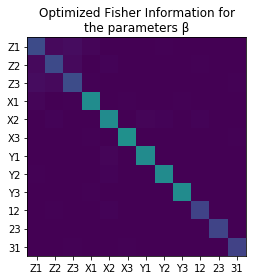

In [129]:
plt.imshow(bn,vmin=0,vmax=2.5)
ticks=['Z1','Z2','Z3','X1','X2','X3','Y1','Y2','Y3','12','23','31']
ax = plt.gca()
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
plt.title('Optimized Fisher Information for\nthe parameters β')
plt.tight_layout()
plt.savefig('FI_b_opt.png',dpi=400,bbox_inches='tight');

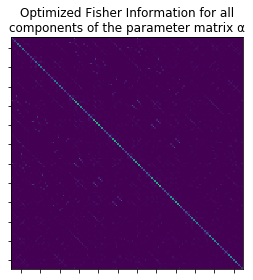

In [130]:
plt.imshow(kn_flat,vmin=0,vmax=2.5)
ax = plt.gca()
ax.set_xticks(range(6,12**2,12))
ax.set_yticks(range(6,12**2,12))
ax.set_xticklabels(['']*12)
ax.set_yticklabels(['']*12)
plt.title('Optimized Fisher Information for all\ncomponents of the parameter matrix α')
plt.tight_layout()
plt.savefig('FI_k_opt.png',dpi=400,bbox_inches='tight');

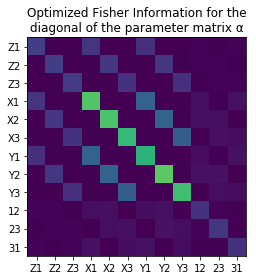

In [131]:
plt.imshow(kn_onlydiag,vmin=0,vmax=2.5)
ax = plt.gca()
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
plt.title('Optimized Fisher Information for the\ndiagonal of the parameter matrix α')
plt.tight_layout()
plt.savefig('FI_kd_opt.png',dpi=400,bbox_inches='tight');

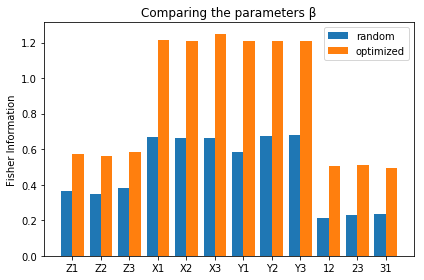

In [132]:
plt.bar(np.arange(12)-0.2,b.diagonal(),width=0.4)
plt.bar(np.arange(12)+0.2,bn.diagonal(),width=0.4)
ax = plt.gca()
ax.set_xticks(range(12))
ax.set_xticklabels(ticks)
plt.legend(['random','optimized'])
plt.ylabel('Fisher Information')
plt.title('Comparing the parameters β')
plt.tight_layout()
plt.savefig('FI_b_compare.png',dpi=400,bbox_inches='tight');

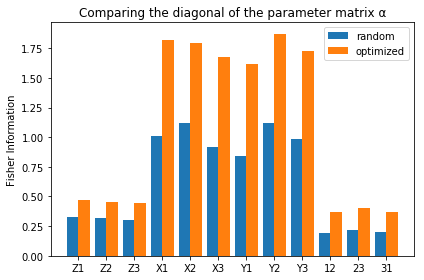

In [133]:
plt.bar(np.arange(12)-0.2,k_onlydiag.diagonal(),width=0.4)
plt.bar(np.arange(12)+0.2,kn_onlydiag.diagonal(),width=0.4)
ax = plt.gca()
ax.set_xticks(range(12))
ax.set_xticklabels(ticks)
plt.legend(['random','optimized'])
plt.ylabel('Fisher Information')
plt.title('Comparing the diagonal of the parameter matrix α')
plt.tight_layout()
plt.savefig('FI_kd_compare.png',dpi=400,bbox_inches='tight');

In [34]:
import sklearn.decomposition

In [35]:
PCA = sklearn.decomposition.PCA(n_components=2)
pca = PCA.fit_transform(opt_drives)
pca_orig = PCA.transform(validation_data[0])

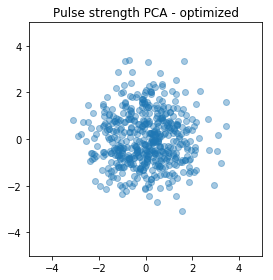

In [134]:
plt.scatter(pca[:,0],pca[:,1],alpha=0.4)
plt.xlim(-5,+5)
plt.ylim(-5,+5)
ax = plt.gca()
ax.set_aspect(1)
plt.title('Pulse strength PCA - optimized')
plt.tight_layout()
plt.savefig('FI_drive_PCA_opt.png',dpi=400,bbox_inches='tight');

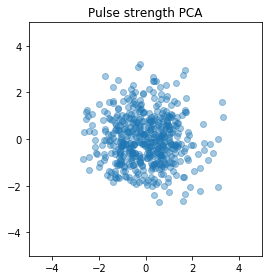

In [135]:
plt.scatter(pca_orig[:,0],pca_orig[:,1],alpha=0.4)
plt.xlim(-5,+5)
plt.ylim(-5,+5)
ax = plt.gca()
ax.set_aspect(1)
plt.title('Pulse strength PCA')
plt.tight_layout()
plt.savefig('FI_drive_PCA.png',dpi=400,bbox_inches='tight');

In [38]:
pca_all      = sklearn.decomposition.PCA(n_components=12).fit(opt_drives)
pca_all_orig = sklearn.decomposition.PCA(n_components=12).fit(validation_data[0])

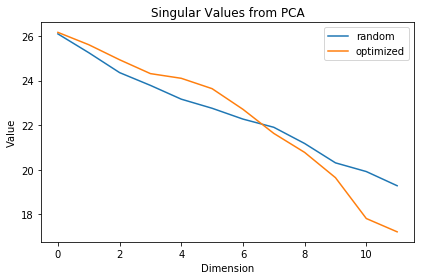

In [136]:
plt.plot(pca_all_orig.singular_values_)
plt.plot(pca_all.singular_values_)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.title('Singular Values from PCA')
plt.legend(['random','optimized'])
plt.tight_layout()
plt.savefig('FI_singvalues.png',dpi=400,bbox_inches='tight')

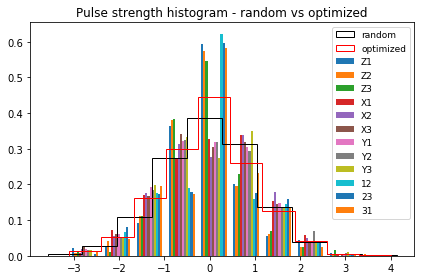

In [137]:
plt.hist(opt_drives,normed=True)
plt.hist(validation_data[0].flatten(),color='black',histtype='step',normed=True)
plt.hist(opt_drives.flatten(),color='red',histtype='step',normed=True)
plt.title('Pulse strength histogram - random vs optimized')
plt.legend(['random','optimized']+ticks,fontsize=9)
plt.tight_layout()
plt.savefig('FI_drive_hist.png',dpi=400,bbox_inches='tight')

In [41]:
np.mean(np.abs(validation_data[0])**2)

1.0012263614503136

In [42]:
np.mean(np.abs(opt_drives)**2)

0.9964510588579097

In [60]:
noise = 0.1
_epsilons_false = np.random.normal(loc=1., scale=noise, size=n)*_epsilons
_etas_false     = np.random.normal(loc=1., scale=noise, size=n)*_etas
_deltas_false   = np.random.normal(loc=1., scale=noise, size=qubitring_ndrives(n))*_deltas
starting_w = qubitring_perfect_pauli_weights(n, _epsilons_false, _etas_false, _deltas_false, noise=0)
validation_data = next(qubitring_datagen(H0, Hdrives, n=n, batch_size=512, Delta=1., seed=17, average_over=float('inf')))
model = Sequential()
model.add(StateProbabilitiesPaulied(nqubits=n, ndrives=nb_drives, paulies=hs,
                                    l1_lambda=2e-4))
model.compile(loss='mse', optimizer=Nadam(lr=5e-4), metrics=['mse', 'mae', 'binary_crossentropy'])

In [96]:
hists = []
hists_opt = []
avgs = [1,2,4,8,16,32,64,128] # a bit too expensive to go to bigger numbers
weights = []
reps = 20
for j,a in enumerate(avgs):
    print(a)
    gen_train = qubitring_datagen(H0, Hdrives, n=n, batch_size=batch_size, Delta=1.,
                                  seed=7, average_over=a, step_reset=1,
                                  spam=0)
    gen_train_opt = qubitring_datagen(H0, Hdrives, n=n, batch_size=batch_size, Delta=1.,
                                  seed=7, average_over=a, step_reset=1,
                                  spam=0, specify_drives=opt_drives)
    model.set_weights(starting_w)
    _hists = []
    for i in range(0,reps):
        print('.',end='')
        #K.set_value(model.optimizer.lr, 5e-4/3**i)
        K.set_value(model.layers[0].regularizer_k.l1,2e-4/(1+(j+1)/len(avgs))**i if i<reps-1 else 0)
        K.set_value(model.layers[0].regularizer_b.l1,2e-4/(1+(j+1)/len(avgs))**i if i<reps-1 else 0)
        #model.set_weights(weights[j][0])
        _hists.append(model.fit_generator(gen_train, verbose=0, steps_per_epoch=100, epochs=1 if i<reps-1 else 4,
                                    validation_data=validation_data,
                                    max_queue_size=500, workers=1).history)
    w1 = model.get_weights()
    model.set_weights(starting_w)
    _hists_opt = []
    for i in range(0,reps):
        print('x',end='')
        #K.set_value(model.optimizer.lr, 5e-4/2**i)
        K.set_value(model.layers[0].regularizer_k.l1,2e-4/(1+(j+1)/len(avgs))**i if i<reps-1 else 0)
        K.set_value(model.layers[0].regularizer_b.l1,2e-4/(1+(j+1)/len(avgs))**i if i<reps-1 else 0)
        #model.set_weights(weights[j][1])
        _hists_opt.append(model.fit_generator(gen_train_opt, verbose=0, steps_per_epoch=100, epochs=1 if i<reps-1 else 4,
                                    validation_data=validation_data,
                                    max_queue_size=500, workers=1).history)
    w2 = model.get_weights()
    print('')
    hists.append(_hists)
    hists_opt.append(_hists_opt)
    weights.append((w1,w2))
    #hists[j] += (_hists)
    #hists_opt[j] += (_hists_opt)
    #weights[j] = ((weights[j][0],w2))

1
.....xxxxx
2
.....xxxxx
4
.....xxxxx
8
.....xxxxx
16
.....xxxxx
32
.....xxxxx
64
.....xxxxx
128
.....xxxxx


In [2]:
import pickle
#with open('opt_est_hist','wb') as f:
#    pickle.dump([hists,hists_opt],f)
#with open('opt_est_hist_redo','wb') as f:
#    pickle.dump([hists,hists_opt],f)
#with open('opt_est_hist_redo2','wb') as f:
#    pickle.dump([hists,hists_opt],f)
#with open('opt_est_hist_redo2_weights', 'wb') as f:
#    pickle.dump(weights, f)
with open('opt_est_hist_redo','rb') as f:
    hists,hists_opt = pickle.load(f)
#with open('opt_est_hist_redo2_weights', 'rb') as f:
#    weights = pickle.load(f)

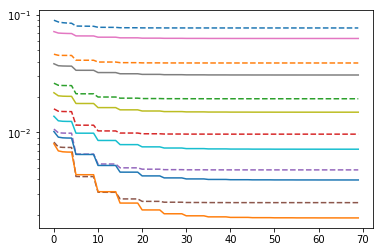

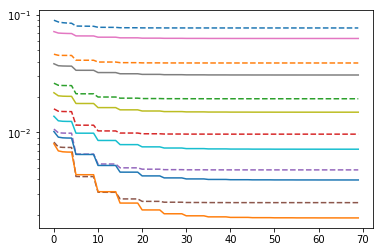

In [5]:
plt.figure()
plt.semilogy(np.array([sum([__['loss'] for __ in _],[]) for _ in hists]).T, '--')
plt.semilogy(np.array([sum([__['loss'] for __ in _],[]) for _ in hists_opt]).T)
plt.gcf()

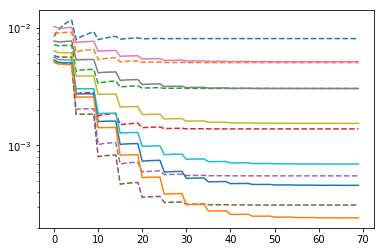

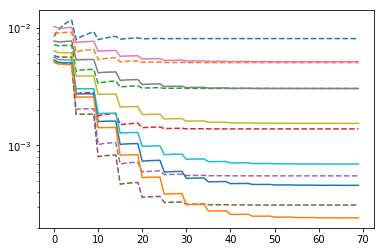

In [6]:
plt.figure()
plt.semilogy(np.array([sum([__['val_loss'] for __ in _],[]) for _ in hists]).T, '--')
plt.semilogy(np.array([sum([__['val_loss'] for __ in _],[]) for _ in hists_opt]).T)
plt.gcf()

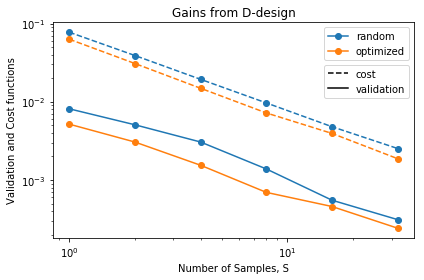

In [4]:
plt.figure()
plt.loglog(avgs[:6], [_[-1]['val_loss'][-1] for _ in hists],'o-')
plt.loglog(avgs[:6], [_[-1]['val_loss'][-1] for _ in hists_opt],'o-')
plt.loglog(avgs[:6], [_[-1]['loss'][-1] for _ in hists],'o--',color='C0')
plt.loglog(avgs[:6], [_[-1]['loss'][-1] for _ in hists_opt],'o--',color='C1')
plt.xlabel('Number of Samples, S')
plt.ylabel('Validation and Cost functions')
l1 = plt.legend(['random','optimized'])
xlim = plt.xlim()
ylim = plt.ylim()
p1, = plt.plot([1,2],[1,2],'k--')
p2, = plt.plot([1,2],[1,2],'k-')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.legend([p1,p2],['cost','validation'],loc=(0.75,0.65))
plt.gca().add_artist(l1)
plt.title('Gains from D-design')
plt.tight_layout()
plt.savefig('FI_ddesign.png',dpi=400,bbox_inches='tight')
plt.gcf();

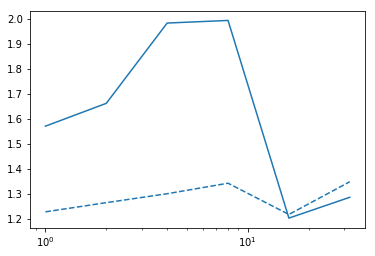

In [115]:
plt.figure()
plt.semilogx(avgs[:6], [_[-1]['val_loss'][-1]/_o[-1]['val_loss'][-1] for _,_o in zip(hists,hists_opt)])
plt.semilogx(avgs[:6], [_[-1]['loss'][-1]/_o[-1]['loss'][-1] for _,_o in zip(hists,hists_opt)],'--',color='C0')
plt.gcf()

In [3]:
avgs = [1,2,4,8,16,32,64,128]